In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import importlib
import functions
import numpy as np
import json
#import seaborn as sns

importlib.reload(functions)

<module 'functions' from 'c:\\Users\\Lenovo\\Documents\\Études\\Ecole_Ingénieur\\2A\\TR-Economie\\Projet_de_recherche\\analysingEffectOfHealthPlanInFrance\\code\\functions.py'>

# Collecting code LPP under the "100% Santé" plan

### Verification of L_SC1 titles who has been modified, erased or added between 2014 and 2024

#### First solution

In [ ]:
diff = {}

for i in range(2024-2015):
    df1 = pd.read_csv(f"../Open-LPP-data/base_complete/OPEN_LPP_{i+2014}.CSV", encoding='ISO-8859-1', sep=';')
    produits1 = df1["L_SC1"].unique().tolist()
    df2 = pd.read_csv(f"../Open-LPP-data/base_complete/OPEN_LPP_{i+2014+1}.CSV", encoding='ISO-8859-1', sep=';')
    produits2 = df2["L_SC1"].unique().tolist()
    difference = list(set(produits1).difference(set(produits2)))
    key = f"{i+2014} - {i+2015}"
    diff[key] = difference

diff

#### Or you could get a list of the different L_SC1 through the years, useable whenever you want

In [5]:
def finding_unique_LPP():
    unique_values=[]
    elements = os.listdir("../Open-LPP-data/base_complete")
    for i in range(int(len(elements)/2)):
        df = pd.read_csv(f"../Open-LPP-data/base_complete/OPEN_LPP_{(i+2014)}.CSV", encoding='ISO-8859-1', sep=';')
        values = df["L_SC1"].unique().tolist()
        for value in values:
            if value in unique_values:
                pass
            else:
                unique_values.append(value)

    return unique_values

## Optical

### Getting the interesting L_SC1 titles

*avant tout il faut regarder si on prend bien tout les l_SC1 en compte parce qu'il y a eu des ajouts, suppressions et modif toutes ces années*

In [6]:
produits = finding_unique_LPP()

In [ ]:
produits

In [ ]:
optical_100 = []
produits_index = [6, 9]

for i in range(len(produits_index)):
    optical_100.append(produits[produits_index[i]])

print(optical_100) #we got 2 interesting L_SC1 title which seem to be eligible to the 100% Santé plan for optical field, we will clean it more precisely.

### Trying to clean the part "PROTHESES OCULAIRES ET FACIALES"

In [9]:
df2023cplt = pd.read_csv(f"../Open-LPP-data/base_complete/OPEN_LPP_2023.CSV", encoding='ISO-8859-1', sep=';')

In [ ]:
print(len(df2023cplt[df2023cplt["L_SC1"]=="PROTHESES OCULAIRES ET FACIALES"]))
df2023cplt[df2023cplt["L_SC1"]=="PROTHESES OCULAIRES ET FACIALES"].tail(3)
#we can notice that there are some shipping fees, we will look if we can disregard those.

In [ ]:
df2023cplt[df2023cplt["L_SC1"]=="PROTHESES OCULAIRES ET FACIALES"]["L_SC2"].unique()

In [ ]:
print(len(df2023cplt[df2023cplt["L_SC1"]=="PROTHESES OCULAIRES ET FACIALES"][df2023cplt["L_SC2"].str.contains("OCULAIRES|FRAIS")]))

In [ ]:
df2023cplt[df2023cplt["L_SC1"]=="PROTHESES OCULAIRES ET FACIALES"][df2023cplt["L_SC2"].str.contains("OCULAIRES|FRAIS")]["L_CODE_LPP"].unique() 
#we figure out that this is not as precise as we would want, but we will keep all that points for the optical field (where L_SC1 = PROTHESES OCULAIRE ET FACIALES)

In [ ]:
final_mask = (df2023cplt["L_SC1"]=="PROTHESES OCULAIRES ET FACIALES") & (df2023cplt["L_SC2"].str.contains("OCULAIRES|FRAIS"))
print(len(df2023cplt[final_mask])) #we get back with 742 lines as expected with the 2nd cell above.

In [ ]:
df_optical_2023 = df2023cplt[final_mask]
df_optical_2023.head()

### Cleaning the dataframe of optical financement in 2014, to get the amounts of money

In [16]:
#we keep the column "REM" to calculate the financing because this is the money effectively gave by the "Sécurité Sociale"
df_optical_2023 = pd.DataFrame({
    "L_SC2" : df_optical_2023["L_SC2"],
    "CODE_LPP" : df_optical_2023["CODE_LPP"],
    "Quantity" : df_optical_2023["QTE"],
    "Financing" : df_optical_2023["REM"]
 })

In [ ]:
df_optical_2023.reset_index(inplace=True)
df_optical_2023.drop(columns="index", inplace=True)
df_optical_2023.head()

In [ ]:
df_optical_2023["Total"] = df_optical_2023['Quantity']*df_optical_2023["Financing"]
df_optical_2023.head(5)

In [ ]:
sum = df_optical_2023["Total"].sum()
sum

### Ajusting the result to the inflation (September 2024)

In [ ]:
optical_HICP = pd.read_csv("../data/HICP/HICP-Corrective-eye-glasses-and-contact-lenses-France-Annual-parts-per-1000.csv")
#optical_HICP = optical_HICP[optical_HICP["TIME PERIOD"]>=2014]
optical_HICP.head()

In [21]:
def adjusted_price(df, initial_price, year_initial_price):
    df = df[df["TIME PERIOD"]>=year_initial_price]
    for i in range(len(df)):
        initial_price = initial_price*(1+(df.iloc[i, 2]/1000))
    return initial_price

In [22]:
adjusted = adjusted_price(optical_HICP, sum, 2023)

In [ ]:
print(adjusted-sum)

### Automation of this processus for every year :

In [24]:
optical_expenditures = {} #{2014:300000, 2015:493000,...}

def adjusted_price(df, initial_price, year_initial_price):
    df = df[df["TIME PERIOD"]>=year_initial_price]
    for i in range(len(df)): #calculating the equivalent for the last year of the df (2024)
        initial_price = initial_price*(1+(df.iloc[i, 2]/1000))
    return initial_price

def gov_optical_exp(inflation_adjustment):
    elements = os.listdir("../Open-LPP-data/base_complete")
    for i in range(int(len(elements)/2)):
        df = pd.read_csv(f"../Open-LPP-data/base_complete/OPEN_LPP_{(i+2014)}.CSV", encoding='ISO-8859-1', sep=';')
        final_mask = (df["L_SC1"]=="PROTHESES OCULAIRES ET FACIALES") & (df["L_SC2"].str.contains("OCULAIRES|FRAIS"))
        #print(i+2014)
        df = df[final_mask]
        df = pd.DataFrame({
        "L_SC2" : df["L_SC2"],
        "CODE_LPP" : df["CODE_LPP"],
        "Quantity" : df["QTE"],
        "Financing" : df["REM"]
        })
        df.reset_index(inplace=True)
        df.drop(columns="index", inplace=True)
        df["Total"] = df['Quantity']*df["Financing"]
        sum = df["Total"].sum()
        key = str(i+2014)

        if inflation_adjustment==True:
            optical_expenditures[key]=adjusted_price(optical_HICP, sum, i+2014)
            #print("test")
        else:
            optical_expenditures[key]=sum
            
    return optical_expenditures


In [ ]:
optical_expenditures_adjusted = gov_optical_exp(inflation_adjustment=True)
optical_expenditures_adjusted = copy.deepcopy(optical_expenditures_adjusted)
optical_expenditures_adjusted

In [ ]:
optical_expenditures_non_adjusted = gov_optical_exp(inflation_adjustment=False)
optical_expenditures_non_adjusted

### Plotting our results

In [ ]:
plt.plot(list(optical_expenditures_adjusted.keys()), list(optical_expenditures_adjusted.values()), marker="o", color="blue", label="Adjusted with HICP (on optical aids)")
plt.plot(list(optical_expenditures_non_adjusted.keys()), list(optical_expenditures_non_adjusted.values()), marker="x", color="red", label="Non-Adjusted")

plt.xlabel("Years")
plt.ylabel("Amount (€)")

plt.title("Evolution of governmental expenditures on optical field", fontweight="bold")
plt.legend()

We take aware of the fact that the trend is the same whether if we take in count the inflation rates or not.

We can deduce, in addition of the fact that the inflation don't touch a lot the health field, that the inflation is disregardable in general in the health field.

## Hearing

### Inflation adjustment

In [ ]:
hearing_HICP = pd.read_csv("../data/HICP/HICP-Hearing-aids-France-Annual-parts-per-1000.csv")
hearing_HICP = hearing_HICP[hearing_HICP["TIME PERIOD"]>=2014]
hearing_HICP.head()
#clearly disregardable, because the HICP's unit is "parts per 1000", so for example, the inflation from 2015 to 2016 equals to 0,07%.
#moreover, as we can see just above this cell, the inflation rates don't have a lot of impact on health field prices

#we had foreseen that with optical field

### Looking for the interesting fields

not so good to find the elements that fits in X field, because I can't see all of the years so the modifications, adds, ... I have to fix it

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy

In [ ]:
dfH2023 = pd.read_csv("../Open-LPP-data/base_complete/OPEN_LPP_2023.CSV", encoding='ISO-8859-1', sep=';')
produits = dfH2023["L_SC1"].unique().tolist() #return a list of the L_SC1 title of all the product and prestation in the df
produits

don't forget the labels that has been modified, added or erased between 2014 and 2024.

In [ ]:
hearing_100 = []
produits_index = [6]

for i in range(len(produits_index)):
    hearing_100.append(produits[produits_index[i]])

print(hearing_100) #we got 2 interesting L_SC1 title which seem to be eligible to the 100% Santé plan for optical field, we will clean it more precisely.

In [ ]:
dfH2023[dfH2023["L_SC1"]=="AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEURS"]["L_SC2"].unique()

All of that seems to fit in the case "Hearing"

In [33]:
dfH2023 = dfH2023[dfH2023["L_SC1"]=="AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEURS"]

### Cleaning data

In [34]:
#we keep the column "REM" to calculate the financing because this is the money effectively gave by the "Sécurité Sociale"
dfH2023 = pd.DataFrame({
    "L_SC2" : dfH2023["L_SC2"],
    "CODE_LPP" : dfH2023["CODE_LPP"],
    "Quantity" : dfH2023["QTE"],
    "Financing" : dfH2023["REM"]
 })

In [ ]:
dfH2023.reset_index(inplace=True)
dfH2023.drop(columns="index", inplace=True)
dfH2023.head()

In [ ]:
dfH2023["Total"] = dfH2023['Quantity']*dfH2023["Financing"]
dfH2023.head(5)

In [ ]:
sum = dfH2023["Total"].sum()
sum

In [38]:
def gov_hearing_exp(inflation_adjustment): #I suppose we can make a function that is able to makes the difference when I want to use it for optical or hearing or ... field, but I don't have much time at this moment, I've to look for it later..
    elements = os.listdir("../Open-LPP-data/base_complete")
    for i in range(int(len(elements)/2)):
        df = pd.read_csv(f"../Open-LPP-data/base_complete/OPEN_LPP_{(i+2014)}.CSV", encoding='ISO-8859-1', sep=';')
        final_mask = (df["L_SC1"]=="AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEURS") | (df["L_SC1"]=="AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEUR")
        #print(i+2014)
        df = df[final_mask]
        df = pd.DataFrame({
        "L_SC2" : df["L_SC2"],
        "CODE_LPP" : df["CODE_LPP"],
        "Quantity" : df["QTE"],
        "Financing" : df["REM"]
        })
        df.reset_index(inplace=True)
        df.drop(columns="index", inplace=True)
        df["Total"] = df['Quantity']*df["Financing"]
        sum = df["Total"].sum()
        key = str(i+2014)

        if inflation_adjustment==True:
            optical_expenditures[key]=adjusted_price(optical_HICP, sum, i+2014)
            #print("test")
        else:
            optical_expenditures[key]=sum
            
    return optical_expenditures

In [ ]:
hearing_expenditures_adjusted = gov_hearing_exp(inflation_adjustment=True)
hearing_expenditures_adjusted = copy.deepcopy(hearing_expenditures_adjusted)
hearing_expenditures_adjusted

In [ ]:
hearing_expenditures_non_adjusted = gov_hearing_exp(inflation_adjustment=False)
hearing_expenditures_non_adjusted

In [ ]:
plt.plot(list(hearing_expenditures_adjusted.keys()), list(hearing_expenditures_adjusted.values()), marker="o", color="blue", label="Adjusted with HICP (on hearing aids)")
plt.plot(list(hearing_expenditures_non_adjusted.keys()), list(hearing_expenditures_non_adjusted.values()), marker="x", color="red", label="Non-Adjusted")

plt.xlabel("Years")
plt.ylabel("Amount (€)")

plt.title("Evolution of governmental expenditures on hearing field", fontweight="bold")
plt.legend()

Results are pretty weird .. So I'm not really confident on what I did here

## Dental

In [42]:
unique_values = finding_unique_LPP()

Dental sector isn't in LPP dataset

# Whole health field

# New analyses after cleaning precisely data

## Different tries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import importlib
import functions
#import seaborn as sns

importlib.reload(functions)

### DiD on code_LPP under 100% Santé plan and code_LPP that isn't in it but is in the field that we are working on.

#### Optical field

In [44]:
import json

with open('../data/potential_100Santé.json', 'r') as file:
    data = json.load(file)

In [ ]:
importlib.reload(functions)

In [50]:
from functions import gov_exp

In [ ]:
classe_A = gov_exp(inflation_adjustment=False, sector="optical", mask={"CLASSE A":["contains", "L_CODE_LPP"]})

In [ ]:
whole_optical = gov_exp(inflation_adjustment=False, sector="optical", mask={"OPTIQUE MEDICALE":["equality", "L_SC1"]})

In [ ]:
plt.plot(list(classe_A[0].keys()), list(classe_A[0].values()), color="blue", label="Classe_A expenditures", marker="o")
plt.plot(list(whole_optical[0].keys()), list(whole_optical[0].values()), color="green", label="Whole field (optical) expenditures", marker="x")

plt.xlabel = "Year"
plt.ylabel = "Amout (€)"

plt.legend()
plt.title(label="Governmental expenditures")
plt.show()

Need to be normalized, so we will be able to compare the trend.

In [47]:
from typing import List
import numpy as np

def normalized_by_mean(list : List[int]):
    normalized_list = []
    mean=np.mean(list)
    for int in list:
        int = int/mean
        normalized_list.append(int)

    return normalized_list

values_A = list(classe_A[0].values())
values_B = list(whole_optical[0].values())
values_A_LPP_codes = list(classe_A[1].values())
values_B_LPP_codes = list(whole_optical[1].values())

In [ ]:
width = 0.35

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

ax1, ax2 = axes[0, 0], axes[0, 1]
ax3, ax4 = axes[1, 0], axes[1, 1]

years_A = np.array([int(year) for year in classe_A[0].keys()])
years_B = np.array([int(year) for year in whole_optical[0].keys()])

ax1.bar(years_A - width/2, normalized_by_mean(values_A), width=width, color="#1f77b4", label="Classe_A expenditures", alpha=0.7)
ax1.bar(years_B + width/2, normalized_by_mean(values_B), width=width, color="#ff7f0e", label="Whole field (optical) expenditures", alpha=0.7)

ax1.set_title('Governmental expenditures (normalized)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Expenditures')
ax1.legend()

years_A_LPP = np.array([int(year) for year in classe_A[1].keys()])
years_B_LPP = np.array([int(year) for year in whole_optical[1].keys()])

ax2.bar(years_A_LPP - width/2, values_A_LPP_codes, width=width, color="#2ca02c", label="NB_LPP_CODES : Classe_A", alpha=0.7)
ax2.bar(years_B_LPP + width/2, values_B_LPP_codes, width=width, color="#d62728", label="NB_LPP_CODES : Whole field (optical)", alpha=0.7)

ax2.set_title('NB of LPP_CODES')
ax2.set_xlabel('Year')
ax2.set_ylabel('Quantity')
ax2.legend()

ax3.bar(years_A_LPP, values_A, width=width, color="#1f77b4", alpha=0.7)

ax3.set_title('Classe_A expenditures')
ax3.set_xlabel('Year')
ax3.set_ylabel('Quantity')
ax3.legend()

ax4.bar(years_A_LPP, values_B, width=width, color="#2ca02c", alpha=0.7)

ax4.set_title('Whole field (optical) expenditures')
ax4.set_xlabel('Year')
ax4.set_ylabel('Quantity')
ax4.legend()

plt.tight_layout()
plt.show()


We can see that the government doesn't finance anymore the items who aren't in "Classe_A"

### DiD on code_LPP under 100% Santé (optical) plan and All fields' in LPP database (optical, hearing)

In [ ]:
importlib.reload(functions)
from functions import gov_exp
whole = gov_exp(inflation_adjustment=False, sector="all", mask={})

values_B = list(whole[0].values())
values_B_LPP_codes = list(whole[1].values())

In [ ]:
values_B_LPP_codes

In [ ]:
width = 0.35

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

ax1, ax2 = axes[0, 0], axes[0, 1]
ax3, ax4 = axes[1, 0], axes[1, 1]

years_A = np.array([int(year) for year in classe_A[0].keys()])
years_B = np.array([int(year) for year in whole[0].keys()])

ax1.plot(years_A, normalized_by_mean(values_A), color="#1f77b4", label="Classe_A expenditures", alpha=0.7)
ax1.plot(years_B, normalized_by_mean(values_B), color="#ff7f0e", label="All fields' expenditures", alpha=0.7)

ax1.set_title('Governmental expenditures (normalized)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Expenditures')
ax1.legend()

years_A_LPP = np.array([int(year) for year in classe_A[1].keys()])
years_B_LPP = np.array([int(year) for year in whole[1].keys()])

ax2.bar(years_A_LPP - width/2, values_A_LPP_codes, width=width, color="#2ca02c", label="NB_LPP_CODES : Classe_A", alpha=0.7)
ax2.bar(years_B_LPP + width/2, values_B_LPP_codes, width=width, color="#d62728", label="NB_LPP_CODES : All fields", alpha=0.7)

ax2.set_title('NB of LPP_CODES')
ax2.set_xlabel('Year')
ax2.set_ylabel('Quantity')
ax2.legend()

ax3.bar(years_A, values_A, width=width, color="#1f77b4", alpha=0.7)

ax3.set_title("Classe_A expenditures")
ax3.set_xlabel('Year')
ax3.set_ylabel('Expenditures')

ax4.bar(years_B, values_B, width=width, color="#ff7f0e", alpha=0.7)

ax4.set_title("All fields' expenditures")
ax4.set_xlabel('Year')
ax4.set_ylabel('Expenditures')

plt.tight_layout()
plt.show()

We see that, here, expenditures are not getting down at all, so we suppose that hearing field keep a certain amount of financement from government. We will verify it below.

### DiD on "classe I" expenditures and whole hearin field

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import json
import importlib
import functions

In [ ]:
importlib.reload(functions)

In [ ]:
classeI_hearing = gov_exp(inflation_adjustment=False, sector="hearing", mask={"AUDIOPROTHESES":["contains", "L_SC1", "or"],"CLASSE I":["contains", "L_CODE_LPP", "and"]})

In [ ]:
whole_hearing = gov_exp(inflation_adjustment=False, sector="hearing", mask={"AUDIOPROTHESES":["contains", "L_SC1", "or"]})

In [ ]:
classeI_hearing

In [ ]:
whole_hearing

In [58]:
years_A = np.array([int(year) for year in classeI_hearing[0].keys()])
years_B = np.array([int(year) for year in whole_hearing[0].keys()])

values_A = list(classeI_hearing[0].values())
values_B = list(whole_hearing[0].values())

values_A_LPP_codes = classeI_hearing[1].values()
values_B_LPP_codes = whole_hearing[1].values()

In [59]:
from functions import normalized_by_mean

In [ ]:
width = 0.35

fig, axes = plt.subplots(2, 2, figsize=(10, 5))

ax1, ax2 = axes[0, 0], axes[0, 1]
ax3, ax4 = axes[1, 0], axes[1, 1]

ax1.plot(years_A, normalized_by_mean(values_A), color="#1f77b4", label="Classe_I expenditures", alpha=0.7)
ax1.plot(years_B, normalized_by_mean(values_B), color="#ff7f0e", label="Hearing expenditures", alpha=0.7)

ax1.set_title('Governmental expenditures (normalized)')
ax1.set_xlabel('Year')
ax1.set_ylabel('Expenditures')
ax1.legend()

ax2.bar(years_A - width/2, values_A_LPP_codes, width=width, color="#2ca02c", label="NB_LPP_CODES : Classe_I", alpha=0.7)
ax2.bar(years_B + width/2, values_B_LPP_codes, width=width, color="#d62728", label="NB_LPP_CODES : Hearing field", alpha=0.7)

ax2.set_title('NB of LPP_CODES')
ax2.set_xlabel('Year')
ax2.set_ylabel('Quantity')
ax2.legend()

ax3.bar(years_A, values_A, width=width, color="#1f77b4", alpha=0.7)

ax3.set_title("Classe_I expenditures")
ax3.set_xlabel('Year')
ax3.set_ylabel('Expenditures')

ax4.bar(years_B, values_B, width=width, color="#ff7f0e", alpha=0.7)

ax4.set_title("Hearing expenditures")
ax4.set_xlabel('Year')
ax4.set_ylabel('Expenditures')

plt.tight_layout()
plt.show()

pour normalized, vaut mieux faire un graphique à points jpense, pcq c'est la tendance qu'on veut voir

voir selon les marques ?

## Brand comparison

In [11]:
import json
with open('../data/potential_100Santé.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

In [12]:
#L_SC1 to keep, to get the brands informations that interest us
processeur = ["AIDE AUDITIVE POUR LES PERSONNES AU-DELA DE LEUR 20EME ANNIVERSAIRE", "AIDES AUDITIVES-PERSONNES <= 20 ANS OU PERSONNES ATTEINTES DE CECITE"]
processeurs = ["AIDE AUDITIVE POUR LES PERSONNES AU-DELA DE LEUR 20EME ANNIVERSAIRE", "AIDES AUDITIVES-PERSONNES <= 20 ANS OU PERSONNES ATTEINTES DE CECITE"]

In [13]:
interesting_keys =["AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEUR", "AUDIOPROTHESES ET ENTRETIEN, REPARATIONS ET ACCESSOIRES POUR PROCESSEURS"]
brands = []
count = 0

for key in interesting_keys:
    if count==0:
        for sc1 in processeur:
            filtered = data[key][sc1]
            for element in filtered:
                parts = element.split(",")
                brand = parts[-1].strip()
                if brand in brands:
                    pass
                else:
                    brands.append(brand)
        count += 1
    else:
        for sc1 in processeurs:
            filtered = data[key][sc1]
            for element in filtered:
                parts = element.split(",")
                brand = parts[-1].strip()
                if brand in brands:
                    pass
                else:
                    brands.append(brand)
print(brands)

['> 20 ANS', 'STARKEY FRANCE', 'SONOVA FRANCE', 'PRODITION', 'WIDEX', 'SIVANTOS', 'GN HEARING SAS', 'BIOTONE TECH', '<= A 20 ANS', '<= 20 ANS', 'SUPERVISION SAS', 'MEDISOUND', 'SIGNIA', 'GAUCHE <= A 20 ANS']


In [14]:
brands_to_remove = [0, 8, 9, 13]
for number in sorted(brands_to_remove, reverse=True):
    del brands[number]
print(brands)

['STARKEY FRANCE', 'SONOVA FRANCE', 'PRODITION', 'WIDEX', 'SIVANTOS', 'GN HEARING SAS', 'BIOTONE TECH', 'SUPERVISION SAS', 'MEDISOUND', 'SIGNIA']


In [23]:
from functions import gov_exp

In [24]:
brand_classI = []
for brand in brands:
    brand_ = brand.replace(" ", "_")
    variable = f"{brand_}_classI"
    variable = gov_exp(inflation_adjustment=False, sector="hearing", mask={"CLASSE I": ["contains", "L_CODE_LPP", "and"], str(brand): ["contains", "L_CODE_LPP", "and"]})
    brand_classI.append(variable)

2014
2014
Empty DataFrame
Columns: [L_CODE_LPP]
Index: []
2015
2015
Empty DataFrame
Columns: [L_CODE_LPP]
Index: []
2016
2016
Empty DataFrame
Columns: [L_CODE_LPP]
Index: []
2017
2017
Empty DataFrame
Columns: [L_CODE_LPP]
Index: []
2018
2018
Empty DataFrame
Columns: [L_CODE_LPP]
Index: []
2019
2019
Empty DataFrame
Columns: [L_CODE_LPP]
Index: []
2020
2020
Empty DataFrame
Columns: [L_CODE_LPP]
Index: []
2021
2021
                                               L_CODE_LPP
686555  AIDE AUDITIVE, CLASSE I, DROITE, > 20 ANS,STAR...
686556  AIDE AUDITIVE, CLASSE I, DROITE, > 20 ANS,STAR...
686557  AIDE AUDITIVE, CLASSE I, DROITE, > 20 ANS,STAR...
686558  AIDE AUDITIVE, CLASSE I, DROITE, > 20 ANS,STAR...
686559  AIDE AUDITIVE, CLASSE I, DROITE, > 20 ANS,STAR...
686560  AIDE AUDITIVE, CLASSE I, DROITE, > 20 ANS,STAR...
686561  AIDE AUDITIVE, CLASSE I, DROITE, > 20 ANS,STAR...
686562  AIDE AUDITIVE, CLASSE I, DROITE, > 20 ANS,STAR...
686563  AIDE AUDITIVE, CLASSE I, DROITE, > 20 ANS,STAR...
6865

In [25]:
count = 0
classI_brands_json = {}
for brand in brands:
    classI_brands_json[brand]=brand_classI[count]
    count +=1

In [26]:
with open('../data/classI_gov_exp_for_different_brands_hearing_field', 'w', encoding='utf-8') as f:
    json.dump(classI_brands_json, f, ensure_ascii=False, indent=4)

In [27]:
brand_classII = []
for brand in brands:
    brand_ = brand.replace(" ", "_")
    variable = f"{brand_}_classII"
    variable = gov_exp(inflation_adjustment=False, sector="hearing", mask={"CLASSE II": ["contains", "L_CODE_LPP", "and"], str(brand): ["contains", "L_CODE_LPP", "and"]})
    brand_classII.append(variable)

2014
2014
Empty DataFrame
Columns: [L_CODE_LPP]
Index: []
2015
2015
Empty DataFrame
Columns: [L_CODE_LPP]
Index: []
2016
2016
Empty DataFrame
Columns: [L_CODE_LPP]
Index: []
2017
2017
Empty DataFrame
Columns: [L_CODE_LPP]
Index: []
2018
2018
Empty DataFrame
Columns: [L_CODE_LPP]
Index: []
2019
2019
Empty DataFrame
Columns: [L_CODE_LPP]
Index: []
2020
2020
                                               L_CODE_LPP
534107  AIDE AUDITIVE, CLASSE II, DROITE, > 20 ANS,STA...
534108  AIDE AUDITIVE, CLASSE II, DROITE, > 20 ANS,STA...
534109  AIDE AUDITIVE, CLASSE II, DROITE, > 20 ANS,STA...
534110  AIDE AUDITIVE, CLASSE II, DROITE, > 20 ANS,STA...
534111  AIDE AUDITIVE, CLASSE II, DROITE, > 20 ANS,STA...
534112  AIDE AUDITIVE, CLASSE II, DROITE, > 20 ANS,STA...
534113  AIDE AUDITIVE, CLASSE II, DROITE, > 20 ANS,STA...
534114  AIDE AUDITIVE, CLASSE II, DROITE, > 20 ANS,STA...
534115  AIDE AUDITIVE, CLASSE II, DROITE, > 20 ANS,STA...
534116  AIDE AUDITIVE, CLASSE II, DROITE, > 20 ANS,STA...
2021

In [28]:
count = 0
classII_brands_json = {}
for brand in brands:
    classII_brands_json[brand]=brand_classII[count]
    count +=1

with open('../data/classII_gov_exp_for_different_brands_hearing_field', 'w', encoding='utf-8') as f:
    json.dump(classII_brands_json, f, ensure_ascii=False, indent=4)

In [29]:
import json
with open('../data/classI_gov_exp_for_different_brands_hearing_field', 'r', encoding='utf-8') as f:
    dataC1 = json.load(f)

with open('../data/classII_gov_exp_for_different_brands_hearing_field', 'r', encoding='utf-8') as f:
    dataC2 = json.load(f)

In [30]:
list_years = np.array([int(year) for year in dataC1["STARKEY FRANCE"][0].keys()])

In [31]:
list_years

array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

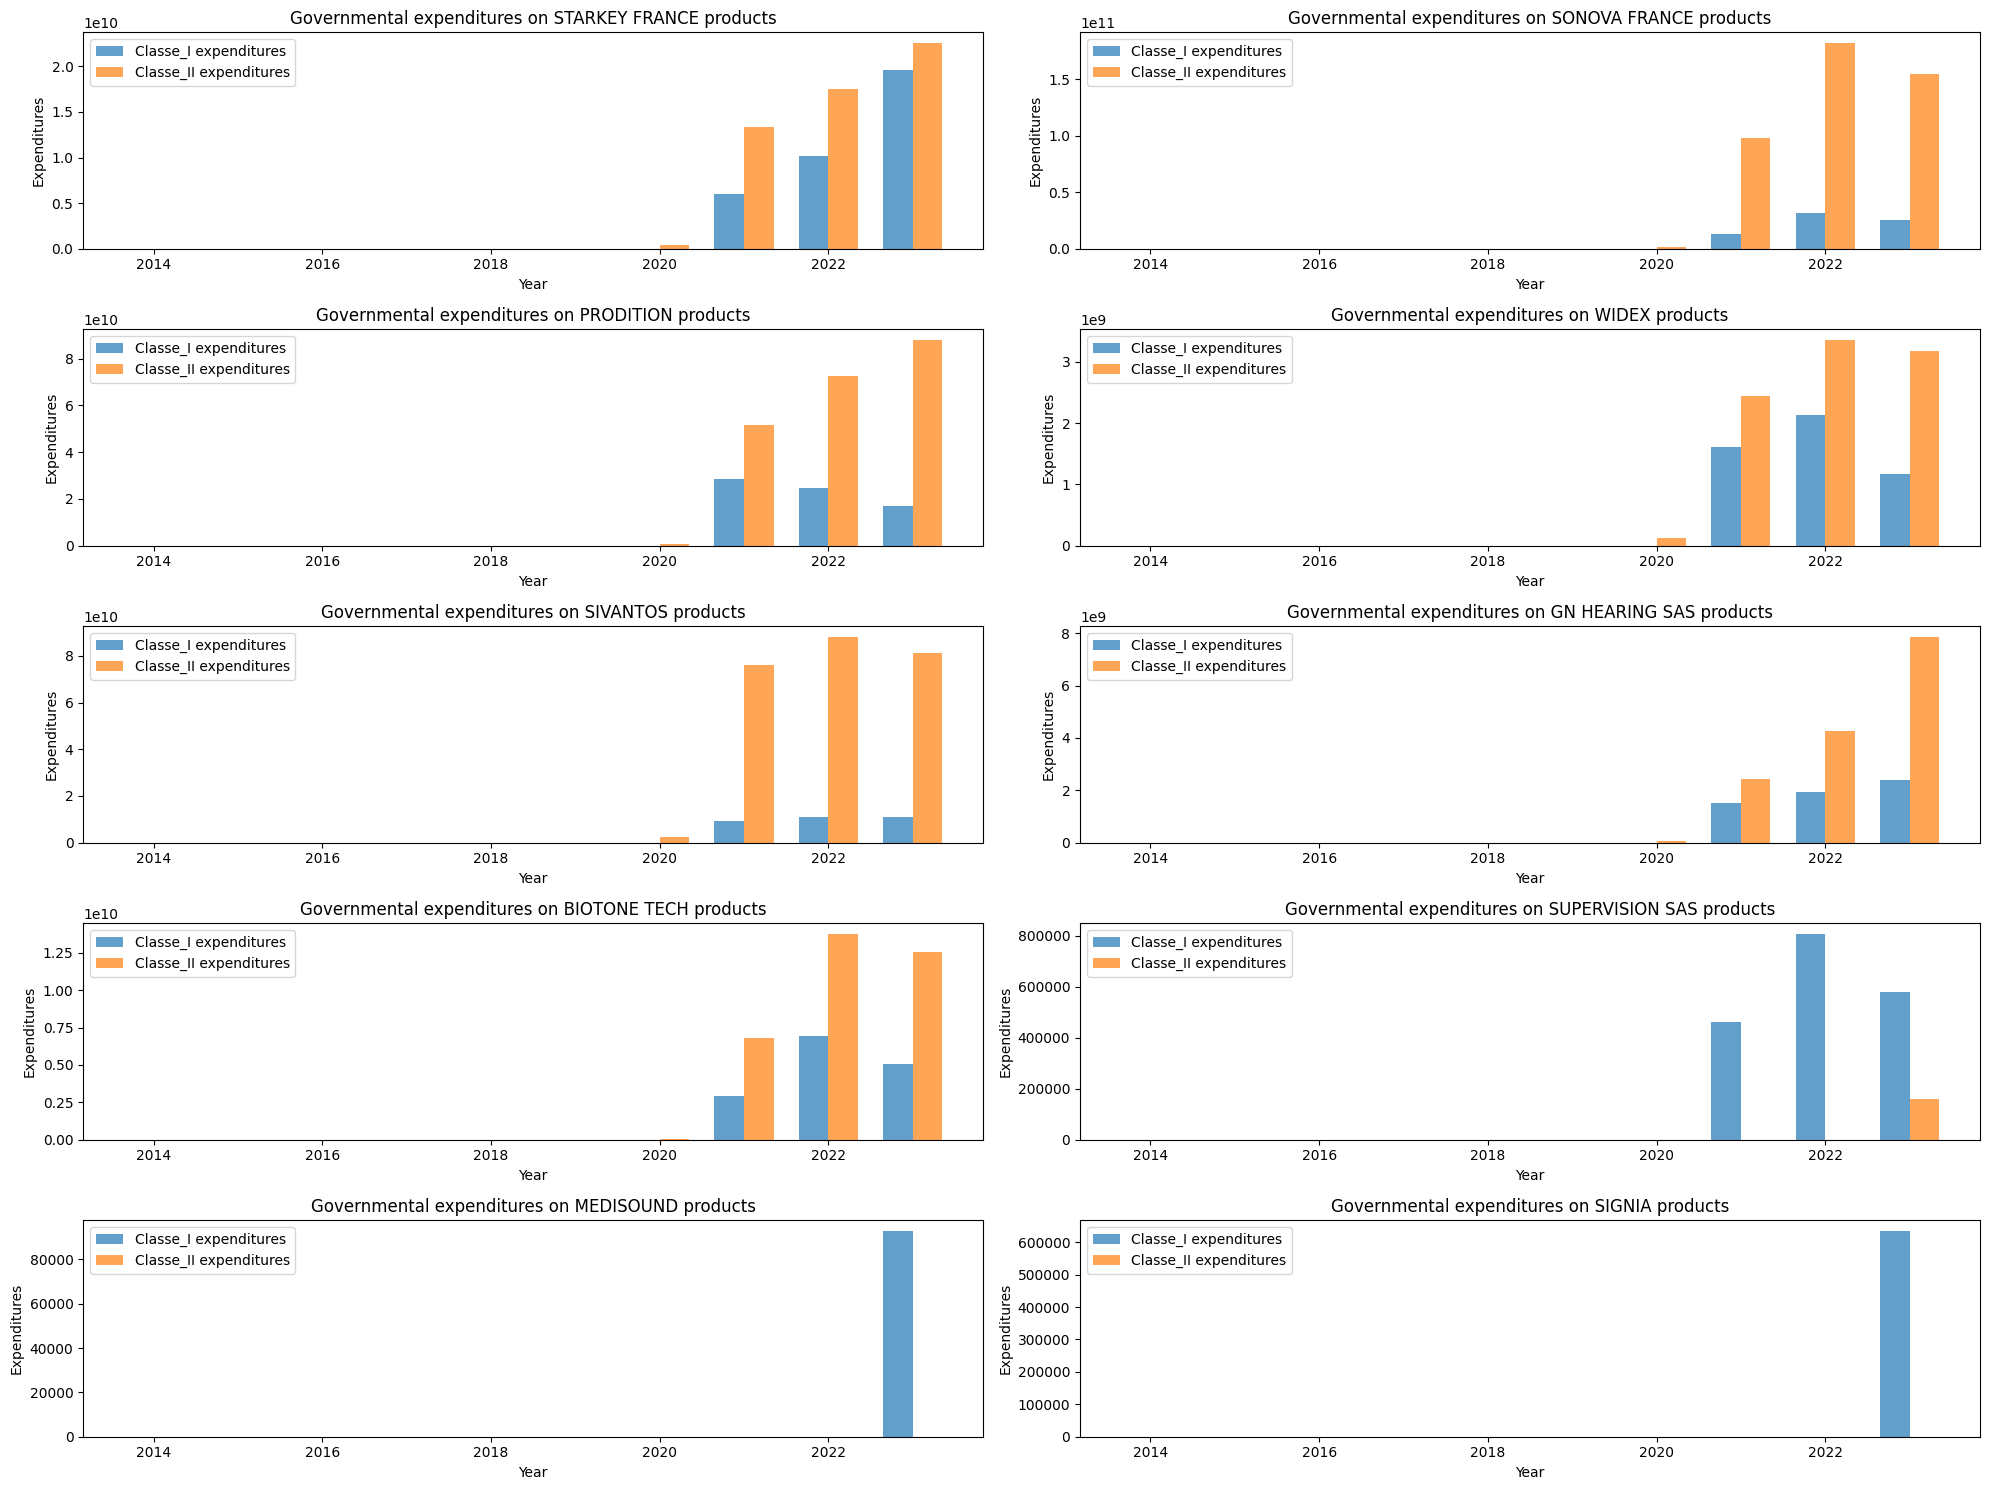

In [34]:
width = 0.35

fig, axes = plt.subplots(5, 2, figsize=(20, 15))

axes = axes.flatten()

count=0

for brand in brands:

    axe = axes[count]
    axe.bar(list_years - width/2, dataC1[brand][0].values(), width=width, color="#1f77b4", label=f"Classe_I expenditures", alpha=0.7)
    axe.bar(list_years + width/2, dataC2[brand][0].values(), width=width, color="#ff7f0e", label=f"Classe_II expenditures", alpha=0.7)
    
    axe.set_title(f'Governmental expenditures on {brand} products')
    axe.set_xlabel('Year')
    axe.set_ylabel('Expenditures')
    axe.legend()

    count += 1

    plt.tight_layout()

plt.show()